In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jeopardy_funcs import get_topics, get_difficulty, prep_data

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

%config InlineBackend.figure_format = 'retina';

## Load in the Questions

In [87]:
df = pd.read_json('JEOPARDY_QUESTIONS1.json')
f"{df.shape[0] - df['question'].nunique()} questions are repeats."

'798 questions are repeats.'

In [3]:
f"There are {df['category'].nunique():,} unique categories in Jeopardy!"

'There are 27,995 unique categories in Jeopardy!'

In [4]:
# bar plot of categories
counts = df['category'].value_counts()

counts.describe()

count    27995.000000
mean         7.748884
std         17.001310
min          1.000000
25%          5.000000
50%          5.000000
75%          5.000000
max        547.000000
Name: category, dtype: float64

In [5]:
print(df.iloc[np.random.choice(range(df.shape[0]), 1)][['question','answer']].values)

[["'Eugene Schueller, who invented a die to cover grey hair, founded this company in Paris in 1947'"
  "L\\'Oréal"]]


# 2: Difficulty of Questions Over Time
### 'Jeopardy!' Round

In [88]:
jeopardy_df = get_difficulty(prep_data(df.loc[df['round'] == 'Jeopardy!', :]))

jeopardy = {}

for difficulty in jeopardy_df['difficulty'].unique():
    W, H, df, vocab = get_topics(jeopardy_df.loc[jeopardy_df['difficulty'] == difficulty], 25)
    idx2word = {idx: word for word, idx in vocab.items()}
    
    sorted_term_relevancy = np.apply_along_axis(np.argsort, axis=1, arr=-H)
    word_relevancy = [list(map(idx2word.get, topic)) for topic in sorted_term_relevancy]
    
    jeopardy[difficulty] = {
        'W': W,
        'H': H,
        'data': df,
        'relevant_words': word_relevancy
    }

/Users/zach.dougherty/anaconda3/envs/torch_env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/zach.dougherty/anaconda3/envs/torch_env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [107]:
for topic in jeopardy[2]['relevant_words']:
    print(topic[:5])

['www', 'http', 'href', 'archive', 'media']
['day', 'time', 'long', 'week', 'national']
['world', 'largest', 'war', 'series', 'capital']
['br', '____', '___', 'partner', 'mp3']
['named', 'king', 'french', 'explorer', 'popular']
['known', 'better', 'born', 'best', 'king']
['city', 'capital', 'largest', 'home', 'museum']
['man', 'woman', 'famous', 'book', 'war']
['like', 'sounds', 'just', 'term', 'good']
['new', 'york', 'jersey', 'orleans', 'hampshire']
['used', 'make', 'term', 'small', 'body']
['seen', 'famous', 'comic', 'style', 'work']
['song', 'hit', 'heard', 'time', 'music']
['country', 'king', 'war', 'nation', 'border']
['type', 'bird', 'animal', 'fruit', 'common']
['big', 'company', 'got', 'book', 've']
['said', 'don', 'people', 'll', 'know']
['film', 'title', 'played', 'character', 'tv']
['old', 'year', 'years', '000', 'time']
['called', 'fish', 'time', 'book', 'originally']
['game', 'home', 'card', 'team', 'play']
['president', 'vice', 'elected', 'future', 'office']
['word', 'le

### 'Double Jeopardy!' Round

In [50]:
dbl_jeopardy = df.drop('topic', axis=1).loc[df['round'] == 'Double Jeopardy!', :]
tfidf_dbl_jeopardy = vectorizer.fit_transform(dbl_jeopardy['question'])

In [53]:
model = NMF(n_components=25, init='random', max_iter=400)
W_dbl_jeopardy = model.fit_transform(tfidf_dbl_jeopardy)  # document-topic, rows=document, cols=topics
H_dbl_jeopardy = model.components_  # topic-term, rows=topics, cols=terms

In [54]:
# topic column
dbl_jtopics = np.apply_along_axis(np.argmax, axis=1, arr=W_dbl_jeopardy)
dbl_jeopardy.loc[:, 'topic'] = dbl_jtopics

Add rank of difficulty per value

In [55]:
dbl_jeopardy.loc[:, 'difficulty'] = dbl_jeopardy.groupby(['show_number']).rank(method='dense')['value']

In [56]:
dbl_jeopardy.sample(3)

,category,air_date,question,value,answer,round,show_number,year,difficulty,topic
5787,...& THE HORSE YOU RODE IN ON!,2010-01-11,"'Ex-welterweight champ Carlos, or a golden-coa...",800.0,a palomino,Double Jeopardy!,5831,2010,2.0,20
149961,LITERATURE,1996-07-17,'The first four chapters of this Bram Stoker w...,200.0,"""Dracula""",Double Jeopardy!,2753,1996,1.0,14
143490,INTERESTING ANAGRAMS,2008-09-09,"'Henny Youngman quipped, ""I just got back from...",1200.0,mother-in-law,Double Jeopardy!,5517,2008,3.0,18


## Comparison

<AxesSubplot:xlabel='topic'>

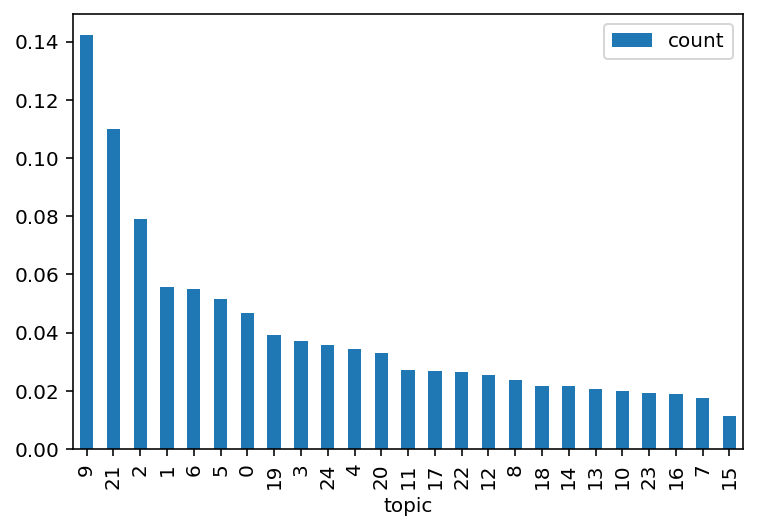

In [83]:
jtopic_cts = jeopardy.groupby('topic').count()[['category']].rename(columns={'category':'count'}).sort_values('count', ascending=False)
jtopic_cts['count'] /= jtopic_cts['count'].sum()

jtopic_cts.plot.bar()

<AxesSubplot:xlabel='topic'>

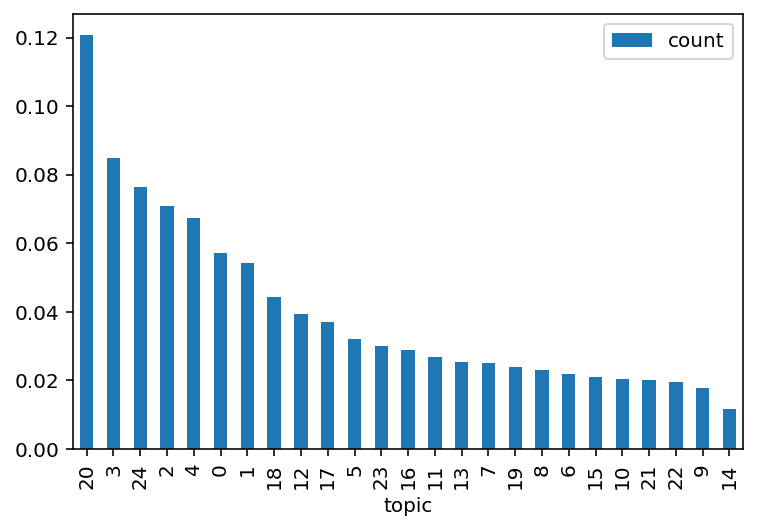

In [84]:
dbl_topic_cts = dbl_jeopardy.groupby('topic').count()[['category']].rename(columns={'category':'count'}).sort_values('count', ascending=False)
dbl_topic_cts['count'] /= dbl_topic_cts['count'].sum()


dbl_topic_cts.plot.bar()

In [97]:
# need to plot the topics present in each difficulty level
diff_topics = jeopardy.groupby(['difficulty','topic']).count()[['category']].rename(columns={'category':'count'}).reset_index(1)

for difficulty in np.unique(diff_topics.index):
    diff_topics.loc[difficulty, 'count'] /= diff_topics.loc[difficulty, 'count'].sum()

In [99]:
diff_topics.loc[1, :]

,topic,count
difficulty,,
1.0,0,0.033190
1.0,1,0.049323
1.0,2,0.084685
1.0,3,0.039338
1.0,4,0.037489
1.0,5,0.049785
1.0,6,0.046133
1.0,7,0.018352
1.0,8,0.023899
